# Context aware pulse gate calibration with Reinforcement Learning

In this notebook, we explore the context aware optimization subroutine through a pulse level gate calibration procedure, taking an Echoed Cross Resonance (ECR) gate as a baseline gate to be optimized by the RL agent.

In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import sys

module_path = os.path.abspath(
    os.path.join(
        "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control"
    )
)
module_path2 = os.path.abspath(
    os.path.join(
        "/Users/arthurstrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/custom_jax_sim"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(module_path2)

In [2]:
# Qiskit imports
from qiskit import pulse, transpile
from qiskit.transpiler import InstructionDurations
from qiskit.circuit import (
    ParameterVector,
    QuantumCircuit,
    QuantumRegister,
    Gate,
    CircuitInstruction,
)

from qconfig import QiskitConfig
from quantumenvironment import QuantumEnvironment
from torch.distributions import Normal

import numpy as np
import tqdm
import time
from typing import Union, Optional, List, Sequence
from IPython.display import clear_output

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


# Circuit macros for environment

Below we define functions defining our way of parametrizing the custom gate we intend to calibrate. In the pulse gate scenario, we define two functions for clearly separating the abstraction layers that are intertwined here.
The function ```apply_parametrized_circuit``` creates a custom parametrized ```Gate``` (which can be derived from a predefined Qiskit gate to retrieve its logical effect) and appends it to a ```QuantumCircuit``` given in input. The parametrization of the gate is provided by the ```params: ParameterVector``` argument of the function and is used to build a custom calibration of the gate. This custom calibration is defined in the second function called ```custom_schedule```, which builds a custom parametrized pulse schedule that can be attached to the gate calibration (see this tutorial for more info: https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html).
In our approach, we design a custom schedule starting from the baseline calibration already available from IBMQ calibration results. The parameters of our custom schedule are in this framework deviations over baseline parameters of the original calibration, meant to evolve to address the particular circuit context in which the gate is going to be executed.

In [ ]:
from qiskit.providers import Backend, BackendV1, BackendV2
from qiskit_experiments.calibration_management import Calibrations
from basis_gate_library import FixedFrequencyTransmon, EchoedCrossResonance
from helper_functions import determine_ecr_params


def custom_schedule(
    backend: Backend,
    physical_qubits: list,
    params: ParameterVector,
    keep_symmetry: bool = True,
):
    """
    Define parametrization of the pulse schedule characterizing the target gate.
    This function can be customized at will, however one shall recall to make sure that number of actions match the
    number of pulse parameters used within the function (throught the params argument).
        :param backend: IBM Backend on which schedule shall be added
        :param physical_qubits: Physical qubits on which custom gate is applied on
        :param params: Parameters of the Schedule/Custom gate
        :param keep_symmetry: Choose if the two parts of the ECR tone shall be jointly parametrized or not

        :return: Parametrized Schedule
    """
    # Load here all pulse parameters names that should be tuned during model-free calibration.
    # Here we focus on real time tunable pulse parameters (amp, angle, duration)
    pulse_features = ["amp", "angle", "tgt_amp", "tgt_angle"]

    # Uncomment lines below to include pulse duration as tunable parameter
    # pulse_features.append("duration")
    duration_window = 0

    global n_actions
    assert n_actions == len(
        params
    ), f"Number of actions ({n_actions}) does not match length of ParameterVector {params.name} ({len(params)})"

    new_params, _, _ = determine_ecr_params(backend, physical_qubits)

    qubits = tuple(physical_qubits)

    if keep_symmetry:  # Maintain symmetry between the two GaussianSquare pulses
        for sched in ["cr45p", "cr45m"]:
            for i, feature in enumerate(pulse_features):
                if feature != "duration":
                    new_params[(feature, qubits, sched)] += params[i]
                else:
                    new_params[
                        (feature, qubits, sched)
                    ] += pulse.builder.seconds_to_samples(duration_window * params[i])
    else:
        num_features = len(pulse_features)
        for i, sched in enumerate(["cr45p", "cr45m"]):
            for j, feature in enumerate(pulse_features):
                if feature != "duration":
                    new_params[(feature, qubits, sched)] += params[i * num_features + j]
                else:
                    new_params[
                        (feature, qubits, sched)
                    ] += pulse.builder.seconds_to_samples(
                        duration_window * params[i * num_features + j]
                    )

    cals = Calibrations.from_backend(
        backend,
        [
            FixedFrequencyTransmon(["x", "sx"]),
            EchoedCrossResonance(["cr45p", "cr45m", "ecr"]),
        ],
        add_parameter_defaults=True,
    )

    # Retrieve schedule (for now, works only with ECRGate(), as no library yet available for CX)
    parametrized_schedule = cals.get_schedule(
        "ecr", physical_qubits, assign_params=new_params
    )
    return parametrized_schedule

In [ ]:
# Pulse gate ansatz


def apply_parametrized_circuit(
    qc: QuantumCircuit,
    params: Optional[ParameterVector] = None,
    tgt_register: Optional[QuantumRegister] = None,
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with Qiskit ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param tgt_register: Quantum Register formed of target qubits
    :return:
    """
    # qc.num_qubits
    global n_actions, backend, target

    gate, physical_qubits = target["gate"], target["register"]
    # x_pulse = backend.defaults().instruction_schedule_map.get('x', (qubit_tgt_register,)).instructions[0][1].pulse
    if params is None:
        params = ParameterVector("theta", n_actions)
    if tgt_register is None:
        tgt_register = qc.qregs[0]

    # Choose below which target gate you'd like to calibrate
    parametrized_gate = Gate("custom_ecr", 2, params=params.params)
    # parametrized_gate = gate.copy()
    # parametrized_gate.params = params.params
    parametrized_schedule = custom_schedule(
        backend=backend, physical_qubits=physical_qubits, params=params
    )
    qc.add_calibration(parametrized_gate, physical_qubits, parametrized_schedule)
    qc.append(parametrized_gate, tgt_register)

# Definition of QuantumEnvironment

## Generic information characterizing the quantum system

The algorithm is built upon Qiskit modules. To specify how to address our quantum system of interest, we therefore adopt the IBM approach to define a quantum backend, on which qubits are defined and can be accessed via control actions and measurements.

The cell below specifies:
- ```physical_qubits```: List of qubit indices which are specifically addressed by controls , namely the ones for which we intend to calibrate a gate upon or steer them in a specific quantum state. Note that this list could include less qubits than the total number of qubits, which can be useful when one wants to take into account crosstalk effects emerging from nearest-neigbor coupling.
- ```sampling_Paulis```: number of Pauli observables  to be sampled from the system: the algorithm relies on the ability to process measurement outcomes to estimate the expectation value of different Pauli operators. The more observables we provide for sampling, the more properties we are able to deduce with accuracy about the actual state that was created when applying our custom controls. For a single qubit, the possible Pauli operators are $\sigma_0=I$, $\sigma_x=X$, $\sigma_y=Y$, $\sigma_z=Z$. For a general multiqubit system, the Pauli observables are tensor products of those single qubit Pauli operators. The algorithm will automatically estimate which observables are the most relevant to sample based on the provided target. The probability distribution from which those observables are sampled is derived from the Direct Fidelity Estimation (equation 3, https://link.aps.org/doi/10.1103/PhysRevLett.106.230501) algorithm. 
- ```N_shots```: Indicates how many measurements shall be done for each provided circuit (that is a specific combination of an action vector and a Pauli observable to be sampled)
- ```n_actions```: Indicates the number of pulse/circuit parameters that characterize our parametrized quantum circuit. For our pulse level ansatz, this number will depend on the number of parameters we are willing to tune in the original two-qubit gate calibration. 
- ```estimator_options```: Options of the Qiskit Estimator primitive. The Estimator is the Qiskit module enabling an easy computation of Pauli expectation values. One can set options to make this process more reliable (typically by doing some error mitigation techniques in post-processing). Works only with Runtime Backend at the moment
- ```abstraction_level``` chosen to encode our quantum circuit. One can choose here to stick to the usual circuit model of quantum computing, by using the ```QuantumCircuit``` objects from Qiskit and therefore set the ```abstraction_level``` to ```"circuit"```. However, depending on the task at hand, one can also prefer to use a pulse description of all the operations in our circuit. This is possible for both real backends and simulators by using respectively Qiskit Runtime and Qiskit Dynamics. In this case, one should define the ansatz circuit above in a pulse level fashion, and the simulation done at the Hamiltonian level, and not only via statevector calculations. In this notebook we set the ```abstraction_level``` to ```"pulse"```. Another notebook at the gate level is available in the repo.

In [ ]:
physical_qubits = [0, 1]
sampling_Paulis = 50
N_shots = 200
n_actions = 4  # Cf number of parameters in custom_schedule function above
abstraction_level = "pulse"

In [ ]:
# Define below Runtime Options of your choice (relevant only for real backends)
from qiskit_ibm_runtime.options import Options, ExecutionOptions, EnvironmentOptions

estimator_options = Options(
    resilience_level=0,
    optimization_level=0,
    execution=ExecutionOptions(shots=N_shots * sampling_Paulis),
)

## Setting up Quantum Backend

### Real backend initialization

Uncomment the cell below to declare a Qiskit Runtime backend. You need an internet connection and an IBM Id  to access this.

In [5]:
"""
Real backend initialization:
Run this cell only if intending to use a real backend, where Qiskit Runtime is enabled
"""
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_nazca"

service = QiskitRuntimeService(
    channel="ibm_quantum", instance="ibm-q-nus/default/default"
)
runtime_backend = service.get_backend(backend_name)

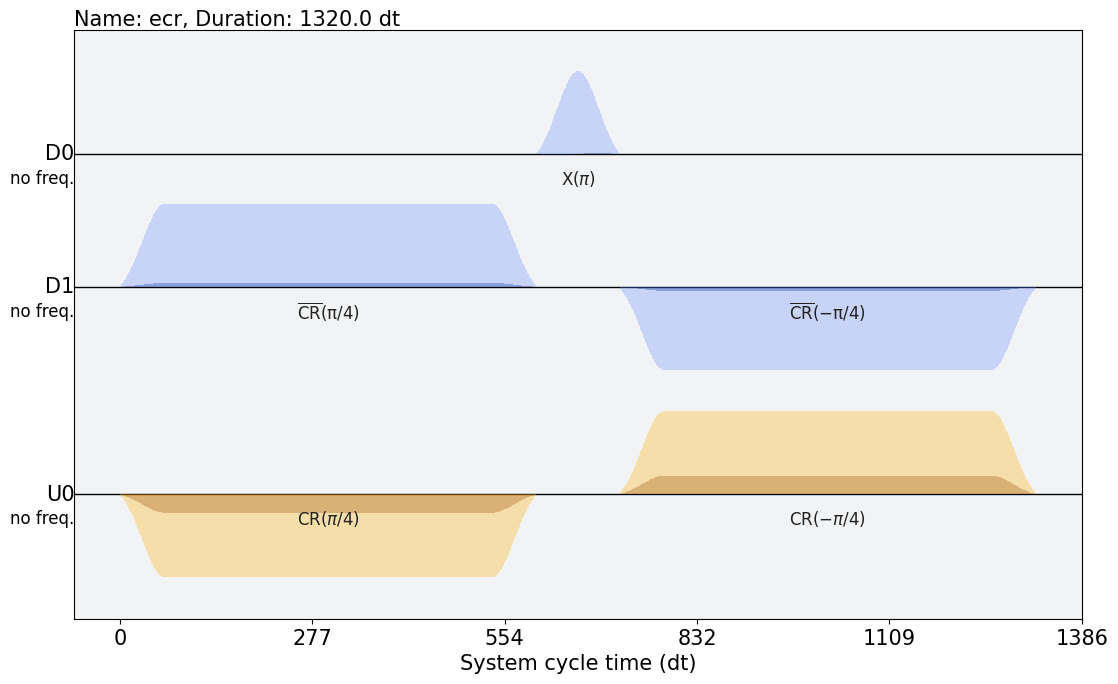

In [6]:
runtime_backend.target.get_calibration("ecr", (0, 1)).draw()

### Simulation backend initialization: Qiskit Dynamics
If you want to run the algorithm over a simulation, one can use Qiskit Dynamics for pulse level simulation of quantum circuits. Below we set the ground for declaring a ```DynamicsBackend```.

This can be done in two ways: 

1. Declare a ```DynamicsBackend``` from a ```FakeBackend``` or ```IBMBackend``` instance and use the ```from_backend()``` method to retrieve the Hamiltonian description of such backend.
2. Alternatively, you can define your own custom Hamiltonian/Linblad that should be used to simulate the multiqubit system of interest, and feed it to a ```Solver``` instance which can be used to declare the ```DynamicsBackend```.
For more information you can check Qiskit Dynamics documentation (https://qiskit.org/documentation/dynamics/apidocs/backend.html)


In [ ]:
from qiskit.providers.fake_provider import FakeHanoi, FakeJakarta, FakeJakartaV2
from helper_functions import get_control_channel_map
from qiskit_dynamics import DynamicsBackend, Solver
from helper_functions import get_solver_and_freq_from_backend
from qiskit_dynamics.array import Array
import jax

jax.config.update("jax_enable_x64", True)
# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")
# import Array and set default backend

Array.set_default_backend("jax")
fake_backend = FakeJakarta()
fake_backend_v2 = FakeJakartaV2()
control_channel_map = get_control_channel_map(fake_backend, physical_qubits)
dt = fake_backend_v2.target.dt
print("Coupling Map: ", list(fake_backend_v2.coupling_map.get_edges()))

In [ ]:
dynamics_options = {
    "seed_simulator": None,  # "configuration": fake_backend.configuration(),
    "control_channel_map": control_channel_map,
    "solver_options": {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt},
}
qubit_properties = fake_backend_v2.qubit_properties(physical_qubits)

# Extract channel frequencies and Solver instance from backend to provide a pulse level simulation enabling
# fidelity benchmarking
channel_freq, solver = get_solver_and_freq_from_backend(
    backend=fake_backend,
    subsystem_list=physical_qubits,
    rotating_frame="auto",
    evaluation_mode="dense",
    rwa_cutoff_freq=None,
    static_dissipators=None,
    dissipator_channels=None,
    dissipator_operators=None,
)
calibration_files = None

In [ ]:
# Using the from_backend method

dynamics_backend = DynamicsBackend.from_backend(
    fake_backend, subsystem_list=physical_qubits, **dynamics_options
)
dynamics_backend.target.qubit_properties = qubit_properties

In [ ]:
print(dynamics_backend.coupling_map)

In [ ]:
print(qubit_properties)

In [ ]:
dim = 3

v = [prop.frequency for prop in qubit_properties]
v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)

static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = (
    static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))
)

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

# build solver
dt = 1 / 4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[
        drive_op0,
        drive_op1,
        drive_op0,
        drive_op1,
        drive_op1,
        drive_op0,
    ],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1", "u2", "u3"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0, "u2": v0, "u3": v1},
    dt=dt,
    evaluation_mode="sparse",
)
# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}

custom_backend2 = DynamicsBackend(
    solver=solver,
    # target = fake_backend_v2.target,
    subsystem_dims=[dim, dim],  # for computing measurement data
    solver_options=solver_options,  # to be used every time run is called
)
backend_target = custom_backend2.target
channel_freq = None
calibration_files = None
do_calibrations = True
# qubit properties

In [ ]:
print(custom_backend2.target)

## Select backend

In [ ]:
# Choose backend among the set defined above: {runtime_backend, dynamics_backend, custom_backend}
from qiskit_ibm_runtime import Estimator, IBMBackend as RuntimeBackend

backend = dynamics_backend

print("Selected Backend: ", backend)
if isinstance(backend, DynamicsBackend):
    print("Subsystem dims: ", backend.options.subsystem_dims)
elif isinstance(backend, RuntimeBackend):
    print("Is Backend a Simulator backend:", backend.simulator)
print("Backend options", backend.options)

In [ ]:
# Wrap all info in one QiskitConfig
# Qiskit_setup = QiskitConfig(parametrized_circuit=apply_parametrized_circuit, backend=backend)
Qiskit_setup = QiskitConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    estimator_options=estimator_options,
    channel_freq=channel_freq,
    solver=solver,
)
Qiskit_setup

## Define quantum target: State preparation or Gate calibration

The target of our optimal control task can be of two different types:
1.  An arbitrary quantum state to prepare with high accuracy
2. A Quantum Gate to be calibrated in a noise-robust manner

Both targets are dictionaries that are identified with a key stating their ```target_type```, which can be either ```"state"``` or ```"gate"```. The type is inferred by the target provided.

For a gate target $G$, one can add the target quantum gate with a ```"gate"``` key specifying a specific instance of a Qiskit ```Gate``` object. Here, we settle for calibrating a ```ECRGate```, which is the two-qubit basis gate of latest IBM devices.
Moreover, a gate calibration requires a set of input states $\{|s_i\rangle \}$ to be provided, such that the agent can try to set the actions such that the fidelity between the anticipated ideal target state (calculated as  $G|s_i\rangle$) and the output state are simultaneously maximized. To ensure a correlation between the average reward computed from the measurement outcomes and the average gate fidelity, the provided set of input states must be tomographically complete. Note that providing the set of ```input_states```as depicted below is optional and should be done only if you have a specific set to implement, by default it is internally set to the Pauli basis preparation stage.

For a state target, one can provide, similarly to an input state, an ideal circuit to prepare it (```"circuit": QuantumCircuit```, or a density matrix (```"dm": DensityMatrix```)..

Another important key that should figure in the dictionary is the ```"register"``` indicating the physical qubits that should be addressed by this target, i.e. upon which qubits should the target be engineered. The register can be a list of indices for qubits to be addressed in the circuit, or a ```QuantumRegister```object. If register is not provided, then by default the target register will be the list of all qubits defined up to ```Gate().num_qubits```.

In [ ]:
# Example of target gate
from qiskit.circuit.library.standard_gates import ECRGate

ECR_tgt = {"gate": ECRGate(), "register": physical_qubits}
target = ECR_tgt
print(target)

In [ ]:
from qiskit.visualization.pulse_v2 import IQXStandard

default_params, instructions, pulses = determine_ecr_params(
    fake_backend, physical_qubits=physical_qubits
)

instructions.draw(backend=fake_backend, style=IQXStandard())

## Declare QuantumEnvironment object
Running the box below declares the QuantumEnvironment instance.

If selected backend is a ```DynamicsBackend```, this declaration launches a series of single qubit gate calibrations (to calibrate X and SX gate). The reason for this is that the Estimator primitive, which enables the computation of Pauli expectation values, requires calibrated single qubit gates for doing Pauli basis rotations (SX and RZ, to perform Hadamard and S gates).

In [ ]:
%%time
q_env = QuantumEnvironment(
    target=target,
    abstraction_level=abstraction_level,
    Qiskit_config=Qiskit_setup,
    sampling_Pauli_space=sampling_Paulis,
    n_shots=N_shots,
    c_factor=0.5,
)

In [ ]:
print(q_env)

In [ ]:
from qiskit.visualization import (
    plot_coupling_map,
    plot_circuit_layout,
    gate_map,
    plot_gate_map,
)
from qiskit.visualization.pulse_v2 import IQXDebugging

plot_gate_map(backend)

# Definition of Circuit context

Now that we have established our ```QuantumEnvironment```, we will now focus on the main research point of this paper, which is to calibrate the target gate based on its location within a specific circuit context. As we will use PyTorch to build the interface between our agent and our environment, we will wrap up our original environment within a ```TorchQuantumEnvironment``` object, which will build a suitable environment for dynamical and contextual gate calibration. But first, we define the quantum circuit in which our target operation will appear.

In [ ]:
target_circuit = QuantumCircuit(2)
target_circuit.h(0)
target_circuit.cx(0, 1)
target_circuit.x([0, 1])
target_circuit.cx(0, 1)
target_circuit.draw("mpl")

To be able to see where our ECR gate shall appear in the circuit, we have to transpile this logical circuit to the backend. To ease the visualization, we add small functions to see the circuit only on relevant physical qubits.

In [ ]:
from helper_functions import remove_unused_wires

transpiled_circ = transpile(
    target_circuit,
    backend,
    initial_layout=physical_qubits,
    basis_gates=["sx", "rz", "ecr", "x"],
    optimization_level=1,
)
remove_unused_wires(transpiled_circ).draw("mpl")

In [ ]:
from qiskit import schedule

print(backend.dt)
schedule(transpiled_circ, backend).draw()

# Definition of TorchQuantumEnvironment

To define the ```TorchQuantumEnvironment``` wrapper, we follow the Gym like definition, where we provide the structure of the observation and action spaces.

The class takes the following inputs:
- ```q_env: QuantumEnvironment```: the baseline object where the information about the backend and the target gate is
- ```circuit_context: QuantumCircuit```: The circuit in which the previously defined target operation is applied. Note that the class will automatically look for all instances of the gate within the circuit and build dedicated subcircuits (truncations) enabling the successive calibration of each gate instance. To be noted here: the gate calibration focuses only on the target qubits defined in the ```QuantumEnvironment```. In Qiskit, we typically look for the ```CircuitInstruction``` object composed of a ```Gate``` object and a set of target qubits on which the gate is applied (both defined in target).
- ```action_space```/```observation_space```: Spaces defining the range and shapes of possible actions/observations.
For now, the observation space is fixed to a set of two integers:
    - the first one indicates which random input state was selected at the beginning of the episode, so that the network have an extra information on the randomness source coming from the reward.
    - the second one indicates which instance of the gate it will calibrate. In the real-time use case, we would like the agent to generate on the fly random actions that will be applied directly for the next gate within the circuit execution. With Qiskit Runtime however, we are not able to generate those actions on the fly and will therefore load all actions associated to each instance of the gate prior to execution.


Moreover, we apply for now a sequential training loop, meaning that we will force the agent to focus on the calibration of the first gate (truncating the circuit just behind its execution) before starting to calibrate the second one (and so forth). The number of iterations per gate instance must be provided with the number ```training_steps_per_gate```.

Since we want to run a contextual gate calibration, we need to know exactly how the circuit will be transpiled on the backend. There is therefore an internal transpilation (without any optimization) that enables the retrieval of all timings of the logical gates indicated above. We also account for the local context happening on nearest neighbor qubits on the chip.

Moreover, as we run this sequential gate calibration for each instance of the target gate within the circuit, one can check the different circuit truncations the agent will go over.

Important note: The target type of the calibration must be a quantum Gate instance (it will not work if target is a quantum state).

In [ ]:
%%time
# Circuit context
from torch_quantum_environment import TorchQuantumEnvironment
from gymnasium.spaces import Box, Space

seed = 10
training_steps_per_gate = 2000
benchmark_cycle = 100
# tgt_instruction_counts = target_circuit.data.count(CircuitInstruction(target_gate, tgt_qubits))
tgt_instruction_counts = 2  # Number of times target Instruction is applied in Circuit
batchsize = 300  # Batch size (iterate over a bunch of actions per policy to estimate expected return) default 100
n_actions = 4  # Choose how many control parameters in pulse/circuit parametrization
min_bound_actions = -0.1
max_bound_actions = 0.1
scale_factor = 0.1
observation_space = Box(
    low=np.array([0, 0]),
    high=np.array([1, tgt_instruction_counts]),
    shape=(2,),
    seed=seed,
)
action_space = Box(
    low=min_bound_actions, high=max_bound_actions, shape=(n_actions,), seed=seed
)

torch_env = TorchQuantumEnvironment(
    q_env,
    target_circuit,
    action_space,
    observation_space,
    batch_size=batchsize,
    training_steps_per_gate=training_steps_per_gate,
    benchmark_cycle=benchmark_cycle,
    intermediate_rewards=False,
    seed=None,
)

In [ ]:
torch_env.circuit_truncations[0].draw("mpl")

In [ ]:
torch_env.circuit_truncations[1].draw("mpl")

In [ ]:
torch_env.baseline_truncations[1].draw("mpl")

In [ ]:
torch_env.estimator.options

# Definition of the Agent

In [ ]:
import torch
import torch.nn as nn

from agent import ActorNetwork, CriticNetwork, Agent

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
hidden_units = [64, 64]
activation_functions = [nn.Tanh(), nn.Tanh(), nn.Tanh()]
include_critic = False
chkpt_dir = "tmp/ppo"
chkpt_dir_critic = "tmp/critic_ppo"

actor_net = ActorNetwork(
    observation_space,
    hidden_units,
    n_actions,
    activation_functions,
    include_critic,
    chkpt_dir,
).to(device)
critic_net = CriticNetwork(
    observation_space, hidden_units, activation_functions, chkpt_dir_critic
).to(device)
agent = Agent(actor_net, critic_net=critic_net).to(device)

## Hyperparameters for training

In [ ]:
"""
-----------------------------------------------------------------------------------------------------
Hyperparameters for RL agent
-----------------------------------------------------------------------------------------------------
"""
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

run_name = "test"
writer = SummaryWriter(f"runs/{run_name}")
# writer.add_text(
#     "hyperparameters",
#     "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
# )
# Hyperparameters for the agent
n_epochs = 10  # Number of epochs : default 1500
num_updates = 700
lr_actor = 0.001  # Learning rate for policy update step
lr_critic = 0.001  # Learning rate for critic (value function) update step

epsilon = 0.2  # Parameter for clipping value (PPO)
critic_loss_coeff = 0.5
optimizer = optim.Adam(agent.parameters(), lr=lr_actor, eps=1e-5)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=lr_actor, eps=1e-5)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=lr_critic, eps=1e-5)
minibatch_size = 40
gamma = 1.0
gae_lambda = 0.95

# Clipping
clip_vloss = True
grad_clip = 0.5
clip_coef = 0.5
normalize_advantage = False

# other coefficients
ent_coef = 0.0

# Training
## Storage setup

In [ ]:
global_step = 0
torch_env.clear_history()
obs = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.observation_space.shape
).to(device)
actions = torch.zeros(
    (tgt_instruction_counts, batchsize) + torch_env.action_space.shape
).to(device)
logprobs = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
rewards = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
dones = torch.zeros((tgt_instruction_counts, batchsize)).to(device)
values = torch.zeros((tgt_instruction_counts, batchsize)).to(device)

train_obs = torch.zeros(
    (batchsize,) + torch_env.observation_space.shape, requires_grad=True
).to(device)
visualization_steps = 10

## Main loop

In [ ]:
for update in tqdm.tqdm(range(1, num_updates + 1)):
    next_obs, _ = torch_env.reset(seed=seed)
    num_steps = torch_env.episode_length(global_step)
    next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
    next_done = torch.zeros(batchsize).to(device)

    # print("episode length:", num_steps)

    for step in range(num_steps):
        global_step += 1
        obs[step] = next_obs
        dones[step] = next_done

        with torch.no_grad():
            mean_action, std_action, critic_value = agent(next_obs)
            mean_action *= scale_factor
            probs = Normal(mean_action, std_action)
            action = torch.clip(
                probs.sample(),
                torch.Tensor(np.array(min_bound_actions)),
                torch.Tensor(np.array(max_bound_actions)),
            )
            logprob = probs.log_prob(action).sum(1)
            values[step] = critic_value.flatten()

        actions[step] = action
        logprobs[step] = logprob
        # next_obs, reward, terminated, truncated, infos = torch_env.step(action.cpu().numpy())
        next_obs, reward, terminated, truncated, infos = torch_env.step(
            action.cpu().numpy()
        )
        done = np.logical_or(terminated, truncated)
        rewards[step] = torch.tensor(reward).to(device)
        next_obs = torch.Tensor(np.array([next_obs] * batchsize)).to(device)
        next_done = torch.Tensor(np.array([int(done)] * batchsize)).to(device)
        # Only print when at least 1 env is done

        # print(f"global_step={global_step}, episodic_return={np.mean(reward)}")
        writer.add_scalar("charts/episodic_return", np.mean(reward), global_step)
        writer.add_scalar("charts/episodic_length", num_steps, global_step)

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(num_steps)):
            if t == num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = (
                delta + gamma * gae_lambda * nextnonterminal * lastgaelam
            )
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + torch_env.observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + torch_env.action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(batchsize)
    clipfracs = []
    for epoch in range(n_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, batchsize, minibatch_size):
            end = start + minibatch_size
            mb_inds = b_inds[start:end]
            new_mean, new_sigma, new_value = agent(b_obs[mb_inds])
            new_dist = Normal(new_mean, new_sigma)
            new_logprob, entropy = new_dist.log_prob(b_actions[mb_inds]).sum(
                1
            ), new_dist.entropy().sum(1)
            logratio = (
                new_logprob - b_logprobs[mb_inds] + torch.log(torch.Tensor([1e-6]))
            )
            ratio = logratio.exp()
            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > epsilon).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if normalize_advantage:  # Normalize advantage
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (
                    mb_advantages.std() + 1e-8
                )

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = new_value.view(-1)
            if clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -clip_coef,
                    clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - ent_coef * entropy_loss + v_loss * critic_loss_coeff

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), grad_clip)
            optimizer.step()

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y
    print("mean", mean_action[0])
    print("sigma", std_action[0])
    print("Average return:", np.mean(torch_env.reward_history, axis=1)[-1])
    # print(np.mean(torch_env.reward_history, axis =1)[-1])
    # print("Circuit fidelity:", torch_env.circuit_fidelity_history[-1])
    # print("Avg gate fidelity:", torch_env.avg_fidelity_history[-1])
    print(torch_env._get_info())
    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar(
        "charts/learning_rate", optimizer.param_groups[0]["lr"], global_step
    )
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar(
        "losses/avg_return", np.mean(torch_env.reward_history, axis=1)[-1], global_step
    )
    # for i in range(num_steps):
    #   writer.add_scalar(f"losses/avg_gate_{i}_fidelity", torch_env.avg_fidelity_history[-1][i], global_step)
    # writer.add_scalar("losses/circuit_fidelity", torch_env.circuit_fidelity_history[-1], global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    if global_step % visualization_steps == 0:
        clear_output(wait=True)  # for animation

torch_env.close()
writer.close()

In [ ]:
torch_env.close()
writer.close()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(torch_env.circuit_fidelity_history)

In [ ]:
plt.plot(torch_env.avg_fidelity_history)

In [ ]:
plt.plot(np.mean(torch_env.reward_history, axis=1))

What is below is not relevant to this notebook

In [ ]:
from qiskit.quantum_info import Operator, average_gate_fidelity
from qiskit.circuit.library.standard_gates import CXGate

my_qc = QuantumCircuit(2, name="custom_cx")
optimal_params = [0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5]
params = [-0.0062, 0.2190, 0.9921, 0.9924, -0.9921, 0.9910, -0.9907]
my_qc.u(np.pi * params[0], np.pi * params[1], np.pi * params[2], 0)
my_qc.u(np.pi * params[3], np.pi * params[4], np.pi * params[5], 1)
my_qc.rzx(np.pi * params[6], 0, 1)
average_gate_fidelity(Operator(my_qc), Operator(CXGate()))

In [ ]:
from qiskit import QuantumCircuit
from qiskit.providers.fake_provider import FakePerth
from qiskit_aer import AerSimulator
from qiskit_experiments.library import ProcessTomography
from qiskit_experiments.framework import BatchExperiment

backend = AerSimulator.from_backend(FakePerth())
qc = QuantumCircuit(1)
qc.x(0)

result = (
    BatchExperiment(
        [ProcessTomography(qc), ProcessTomography(qc)],
        backend=backend,
        flatten_results=True,
    )
    .run()
    .block_for_results()
)
print(result.analysis_results("process_fidelity"))

In [ ]:
result.analysis_results("process_fidelity")[0].value

In [ ]:
result.analysis_results("process_fidelity")[1].value